In [1]:
import os

import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine, URL

from splot import esda as esdaplot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn
import contextily

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/

In [2]:
db_url = URL.create(
    drivername="postgresql",
    username=os.environ["DB_USER"],
    password=os.environ["DB_PASSWORD"],
    host=os.environ["DB_HOST"],
    port=os.environ["DB_PORT"],
    database=os.environ["DB_NAME"],
)

db = create_engine(db_url)

In [3]:
incidents_gdf = gpd.read_postgis("SELECT * FROM geo_accidents_mn", db)

incidents_gdf.head()

icr incident_type       incident_date            district  \
0  20601015        Injury 2020-03-04 07:35:00      2600 St. Cloud   
1  17901947        Injury 2017-09-09 18:39:00  2900 Detroit Lakes   
2  20902058        Injury 2020-12-07 16:30:00  2900 Detroit Lakes   
3  19901575        Injury 2019-07-28 13:28:00  2900 Detroit Lakes   
4  17900227        Injury 2017-01-21 10:58:00  2900 Detroit Lakes   

                                location_description road_condition  \
0  Highway 4 at County Road 28, Danielson Twp, Me...            Dry   
1  Eastbound Hwy 10 between Bluffton and Wadena, ...            Dry   
2  Westbound Hwy 10 MP87, BLUFFTON TWP, Otter Tai...            Dry   
3  10 Highway / 77 County Road, Bluffton, Otter T...            Wet   
4  East bound Hwy 10 west of Bluffton, Bluffton T...            Wet   

   vehicles_involved          x          y                        geom  \
0                  2 -94.696530  45.037050  POINT (-94.69653 45.03705)   
1                  1 -95.233773  46.467046  POINT (-95.23377 46.46705)   
2                  1 -95.244858  46.467910  POINT (-95.24486 46.46791)   
3                  1 -95.234587  46.468097  POINT (-95.23459 46.46810)   
4                  3 -95.244858  46.467910  POINT (-95.24486 46.46791)   

   city_id  
0        2  
1        3  
2        3  
3        3  
4        3

In [4]:
ctu_gdf = gpd.read_postgis("SELECT * FROM ctu_accidents", db)

ctu_gdf.head()

ctu_name                  class   county    pop  total_road_length  \
0   Danielson               TOWNSHIP   Meeker    282         537483.168   
1    McGregor               TOWNSHIP   Aitkin    103         241497.213   
2     Sartell                   CITY  Stearns  17412         732280.475   
3       Effie  UNORGANIZED TERRITORY   Itasca      0         706974.192   
4  Lino Lakes                   CITY    Anoka  21236        1410507.550   

   aadt_sum    aadt_mean                                               geom  \
0    1642.0   328.400000  POLYGON ((-94.63485 45.06580, -94.63486 45.051...   
1   11054.0  1579.142857  POLYGON ((-93.19045 46.68031, -93.19017 46.672...   
2  233611.0  4767.571429  MULTIPOLYGON (((-94.26355 45.60480, -94.25787 ...   
3    2477.0   123.850000  POLYGON ((-93.46600 47.89497, -93.46601 47.894...   
4  534331.0  4379.762295  POLYGON ((-93.01970 45.21074, -93.01996 45.196...   

     id  total_incident_count predicted_count     lmi_i  lmi_q  lmi_p  \
0     2                     1            None  0.139501      3  0.181   
1     6                     5            None  0.060457      1  0.343   
2     7                     8            None  0.027296      1  0.257   
3  1035                     0            None  0.221870      3  0.140   
4  2543                     7            None  0.129286      3  0.008   

   lmi_sig lmi_label  
0        0        NS  
1        0        NS  
2        0        NS  
3        0        NS  
4        1        LL

In [5]:
# PREVENTING DIV BY 0 ERROR
ctu_gdf['total_road_length'] = ctu_gdf['total_road_length'].replace(0, 1)


# Standardize
ctu_gdf["rd_stdrd_incidents"] = (ctu_gdf["total_incident_count"] / ctu_gdf["total_road_length"]) * 1000

ctu_gdf.head()

ctu_name                  class   county    pop  total_road_length  \
0   Danielson               TOWNSHIP   Meeker    282         537483.168   
1    McGregor               TOWNSHIP   Aitkin    103         241497.213   
2     Sartell                   CITY  Stearns  17412         732280.475   
3       Effie  UNORGANIZED TERRITORY   Itasca      0         706974.192   
4  Lino Lakes                   CITY    Anoka  21236        1410507.550   

   aadt_sum    aadt_mean                                               geom  \
0    1642.0   328.400000  POLYGON ((-94.63485 45.06580, -94.63486 45.051...   
1   11054.0  1579.142857  POLYGON ((-93.19045 46.68031, -93.19017 46.672...   
2  233611.0  4767.571429  MULTIPOLYGON (((-94.26355 45.60480, -94.25787 ...   
3    2477.0   123.850000  POLYGON ((-93.46600 47.89497, -93.46601 47.894...   
4  534331.0  4379.762295  POLYGON ((-93.01970 45.21074, -93.01996 45.196...   

     id  total_incident_count predicted_count     lmi_i  lmi_q  lmi_p  \
0     2                     1            None  0.139501      3  0.181   
1     6                     5            None  0.060457      1  0.343   
2     7                     8            None  0.027296      1  0.257   
3  1035                     0            None  0.221870      3  0.140   
4  2543                     7            None  0.129286      3  0.008   

   lmi_sig lmi_label  rd_stdrd_incidents  
0        0        NS            0.001861  
1        0        NS            0.020704  
2        0        NS            0.010925  
3        0        NS            0.000000  
4        1        LL            0.004963

## Local Moran's I

In [6]:
from pysal.explore import esda
from pysal.lib import weights

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [7]:
# Extract the points count as a NumPy array
data = ctu_gdf["rd_stdrd_incidents"].values

# Create a weights matrix (W) for the spatial relationship between polygons
# You can use different methods to construct the weights matrix, e.g., queen or rook
w = weights.Queen.from_dataframe(ctu_gdf)

# Perform Local Moran's I analysis
moran_loc = esda.Moran_Local(data, w)

# Add the Local Moran's I values and p-values as columns in the GeoDataFrame
ctu_gdf['lmi_i'] = moran_loc.Is
ctu_gdf['lmi_p'] = moran_loc.p_sim
ctu_gdf['lmi_sig'] = 1 * (moran_loc.p_sim < 0.05)
ctu_gdf['lmi_q'] = moran_loc.q

# LABELS
labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
ctu_gdf["lmi_label"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)),
    index=ctu_gdf.index
).map(labels)

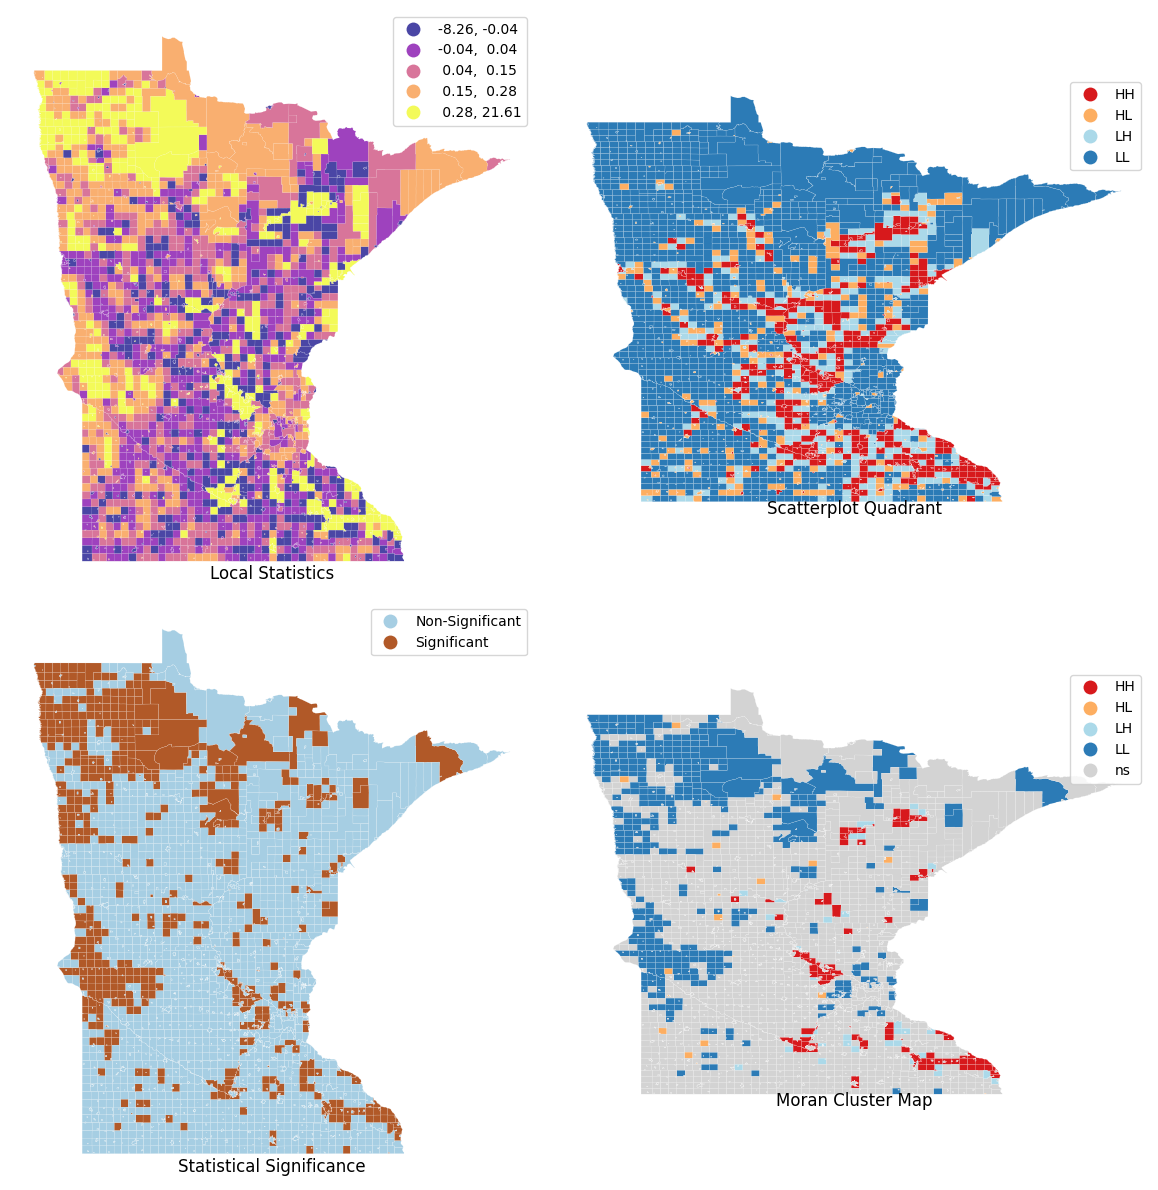

In [8]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
ctu_gdf.assign(
    Is=moran_loc.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(moran_loc, ctu_gdf, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (moran_loc.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=ctu_gdf.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
ctu_gdf.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(moran_loc, ctu_gdf, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

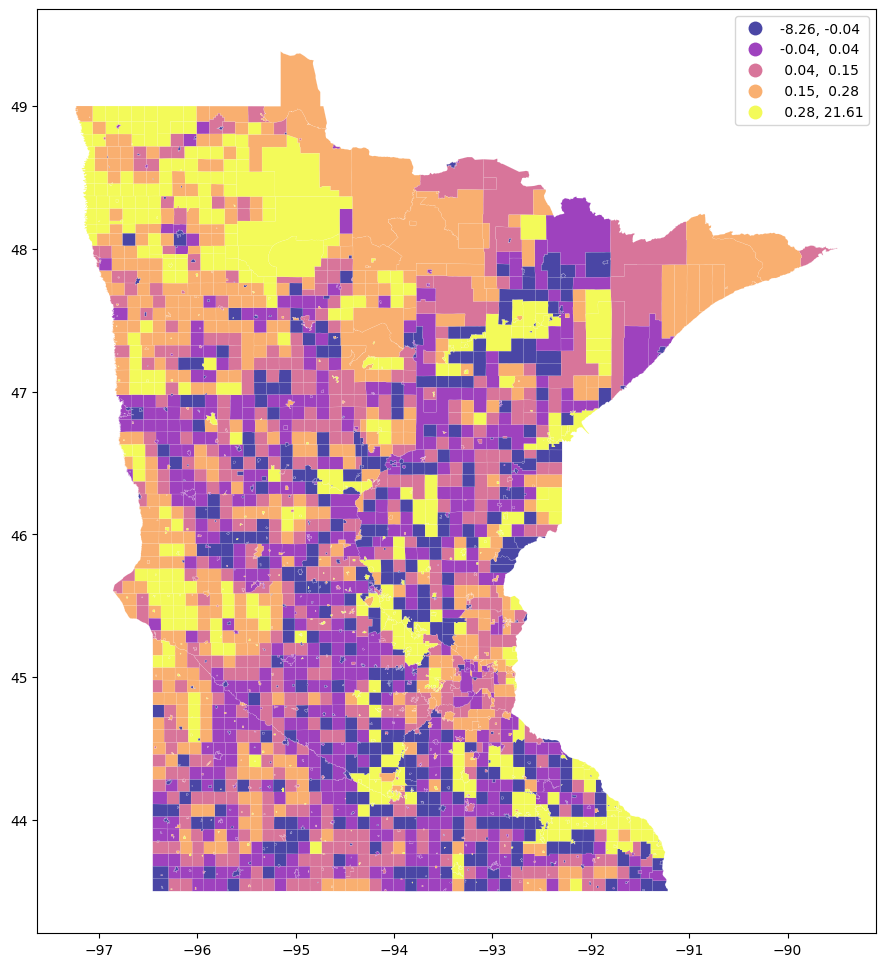

In [18]:
ctu_gdf.assign(
    Is=moran_loc.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    figsize=(12, 12)
);

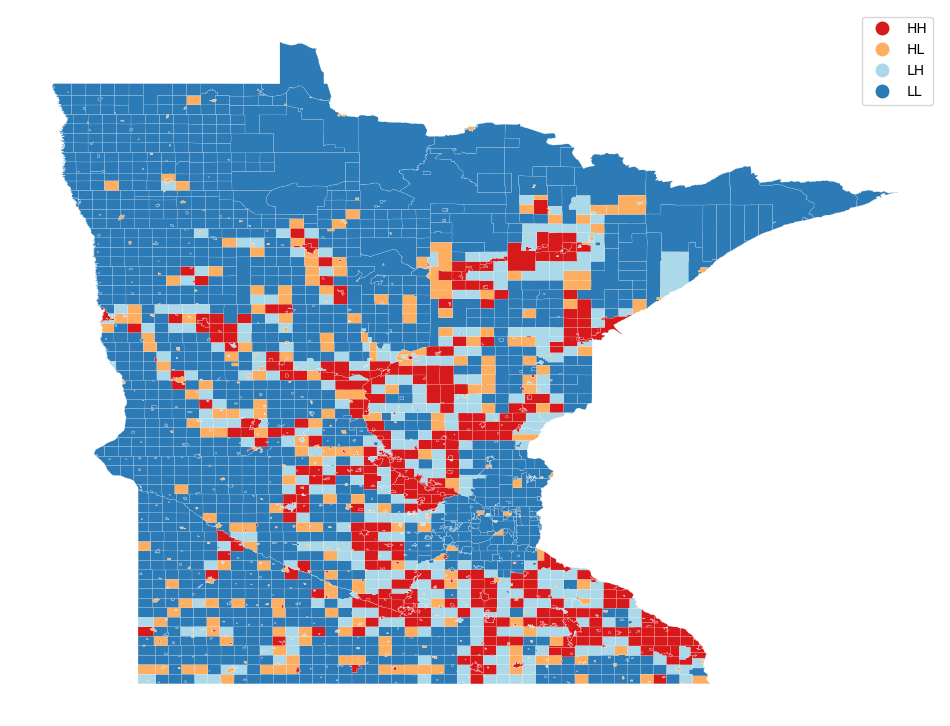

In [19]:
esdaplot.lisa_cluster(moran_loc, ctu_gdf, p=1, figsize=(12, 12));

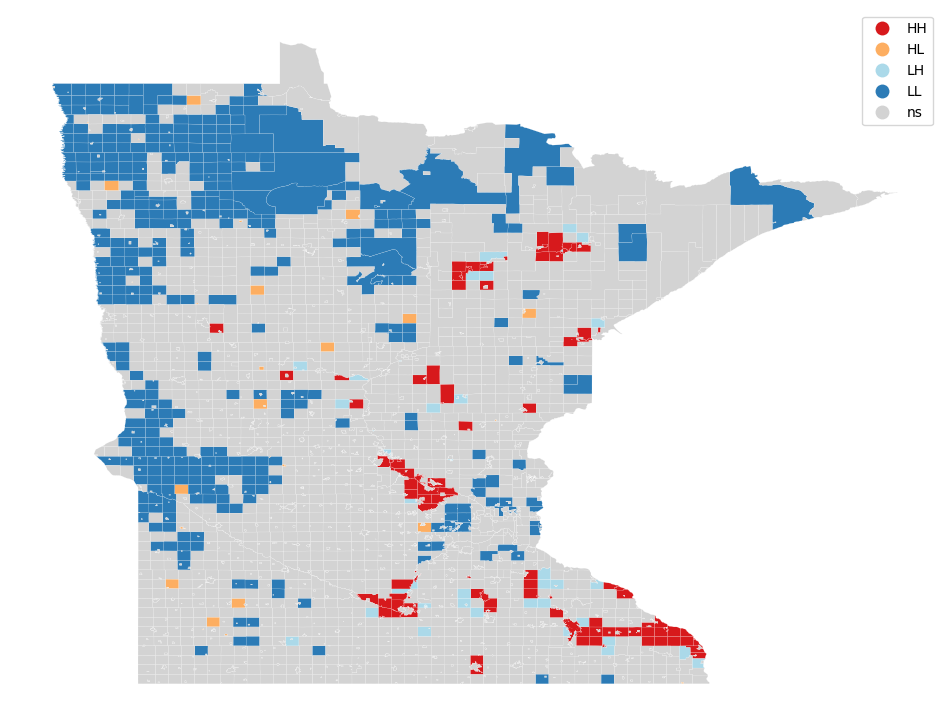

In [20]:
esdaplot.lisa_cluster(moran_loc, ctu_gdf, p=0.05, figsize=(12, 12));

## ADBSCAN

In [21]:
from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls
import numpy as np

### SKIP

In [22]:
incidents_gdf["X"] = incidents_gdf.geometry.x
incidents_gdf["Y"] = incidents_gdf.geometry.y

# Get clusters
adbs = ADBSCAN(0.15, incidents_gdf.shape[0] * 0.01, pct_exact=0.5, reps=50, keep_solus=True)
np.random.seed(1234)
adbs.fit(incidents_gdf)

ADBSCAN(eps=0.15, keep_solus=True, min_samples=99.59, pct_exact=0.5, reps=50)

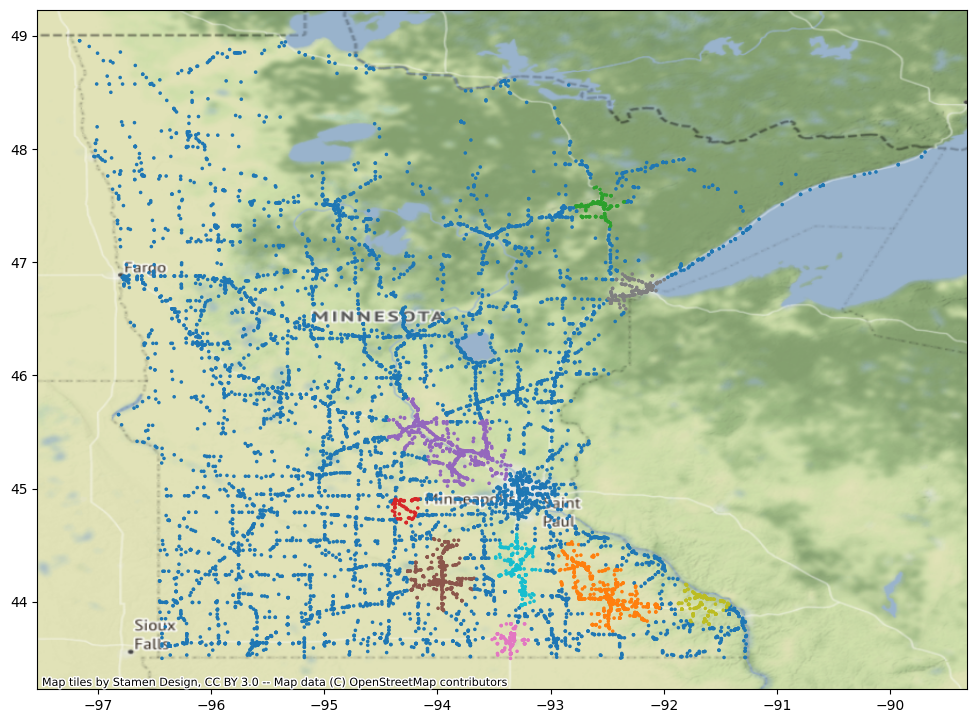

In [23]:
ax = incidents_gdf.assign(lbls=adbs.votes["lbls"])\
    .plot(column="lbls",
        categorical=True,
        markersize=2.5,
        figsize=(12, 12)
    )
contextily.add_basemap(ax, crs=incidents_gdf.crs.to_string());

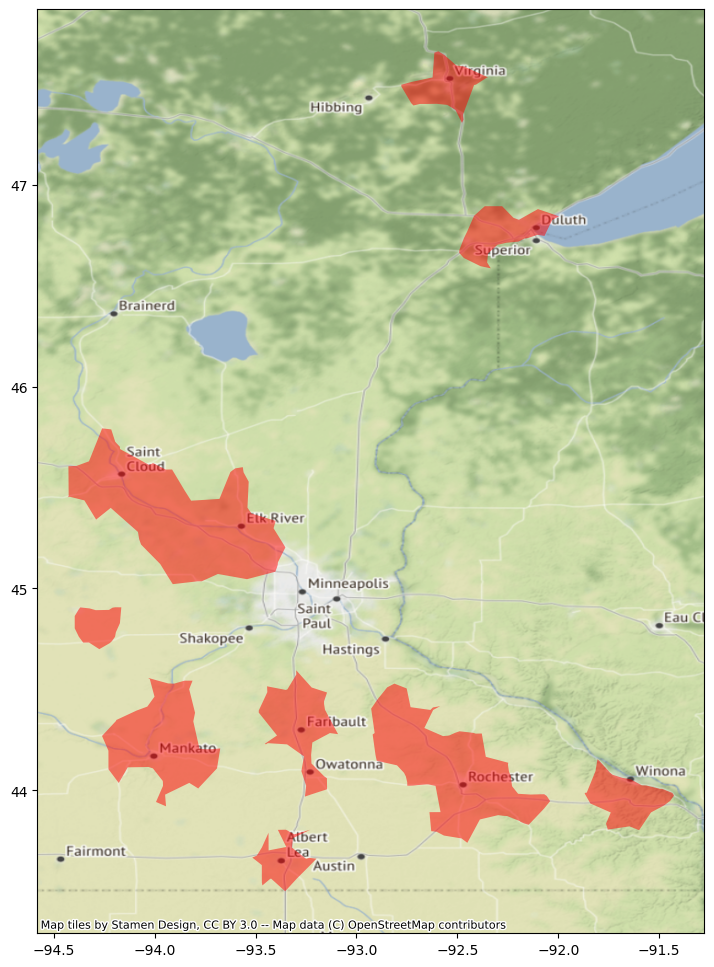

In [24]:
polys = get_cluster_boundary(adbs.votes["lbls"], incidents_gdf, crs=incidents_gdf.crs)

ax = polys.plot(alpha=0.5, color="red", figsize=(12, 12))
contextily.add_basemap(ax, crs=polys.crs.to_string());

### Monthly ADBSCAN

In [25]:
# Create Month/Year ID
incidents_gdf['year'] = incidents_gdf['incident_date'].dt.to_period('Y').astype(str).astype(int)

incidents_gdf["X"] = incidents_gdf.geometry.x
incidents_gdf["Y"] = incidents_gdf.geometry.y

In [26]:
df_list = []

for timestep in incidents_gdf.year.unique():
    year_df = incidents_gdf.loc[(incidents_gdf['year'] == timestep)].copy()
    
    yr_adbs = ADBSCAN(0.15, year_df.shape[0] * 0.01, pct_exact=0.5, reps=50, keep_solus=True)
    yr_adbs.fit(year_df)
    
    mo_polys = get_cluster_boundary(yr_adbs.votes["lbls"], year_df, crs=year_df.crs)
    
    data = {'year': timestep, 'geometry': mo_polys}
    
    footprint_gdf = gpd.GeoDataFrame(data)
    
    df_list.append(footprint_gdf)
    
yearly_footprints = pd.concat(df_list)

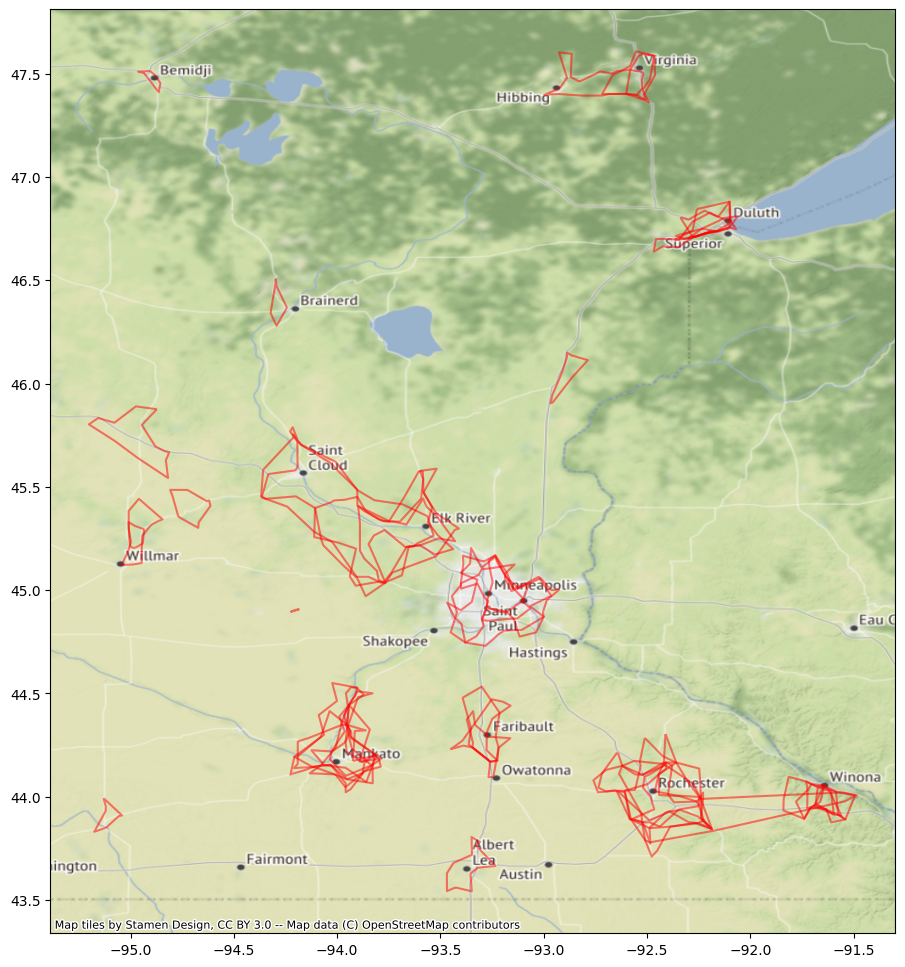

In [27]:
ax = yearly_footprints.boundary.plot(alpha=0.5, color="red", figsize=(12, 12))
contextily.add_basemap(ax, crs=yearly_footprints.crs.to_string());

In [28]:
# CREDITS: https://gis.stackexchange.com/questions/387773/count-overlapping-features-using-geopandas

import shapely

def count_overlapping_features(in_gdf):
    # Get the name of the column containing the geometries
    geom_col = in_gdf.geometry.name
    
    # Setting up a single piece that will be split later
    input_parts = [in_gdf.unary_union.buffer(0)]
    
    # Finding all the "cutting" boundaries. Note: if the input GDF has 
    # MultiPolygons, it will treat each of the geometry's parts as individual
    # pieces.
    cutting_boundaries = []
    for i, row in in_gdf.iterrows():
        this_row_geom = row[geom_col]
        this_row_boundary = this_row_geom.boundary
        if this_row_boundary.geom_type[:len('multi')].lower() == 'multi':
            cutting_boundaries = cutting_boundaries + list(this_row_boundary.geoms)
        else:
            cutting_boundaries.append(this_row_boundary)
    
    
    # Split the big input geometry using each and every cutting boundary
    for boundary in cutting_boundaries:
        splitting_results = []
        for j,part in enumerate(input_parts):
            new_parts = list(shapely.ops.split(part, boundary).geoms)
            splitting_results = splitting_results + new_parts
        input_parts = splitting_results
    
    # After generating all of the split pieces, create a new GeoDataFrame
    new_gdf = gpd.GeoDataFrame({'id':range(len(splitting_results)),
                                geom_col:splitting_results,
                                },
                                crs=in_gdf.crs,
                                geometry=geom_col)
    
    # Find the new centroids.
    new_gdf['geom_centroid'] = new_gdf.centroid
    
    # Starting the count at zero
    new_gdf['count_intersections'] = 0
    
    # For each of the `new_gdf`'s rows, find how many overlapping features 
    # there are from the input GDF.
    for i,row in new_gdf.iterrows():
        new_gdf.loc[i,'count_intersections'] = in_gdf.intersects(row['geom_centroid']).astype(int).sum()
        pass
    
    # Dropping the column containing the centroids
    new_gdf = new_gdf.drop(columns=['geom_centroid'])[['id','count_intersections',geom_col]]
    
    return new_gdf

In [29]:
# TRYING SIMPLIFICATION BEFORE UNION
yearly_footprints_simplified = gpd.GeoDataFrame({"geometry": yearly_footprints.buffer(10, join_style=1).buffer(-10, join_style=1)})

/var/folders/lj/t6r63s3x54x8r756999yfktr0000gn/T/ipykernel_97168/2481029564.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  yearly_footprints_simplified = gpd.GeoDataFrame({"geometry": yearly_footprints.buffer(10, join_style=1).buffer(-10, join_style=1)})


In [34]:
union_df = count_overlapping_features(yearly_footprints_simplified)

/var/folders/lj/t6r63s3x54x8r756999yfktr0000gn/T/ipykernel_97168/849485793.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


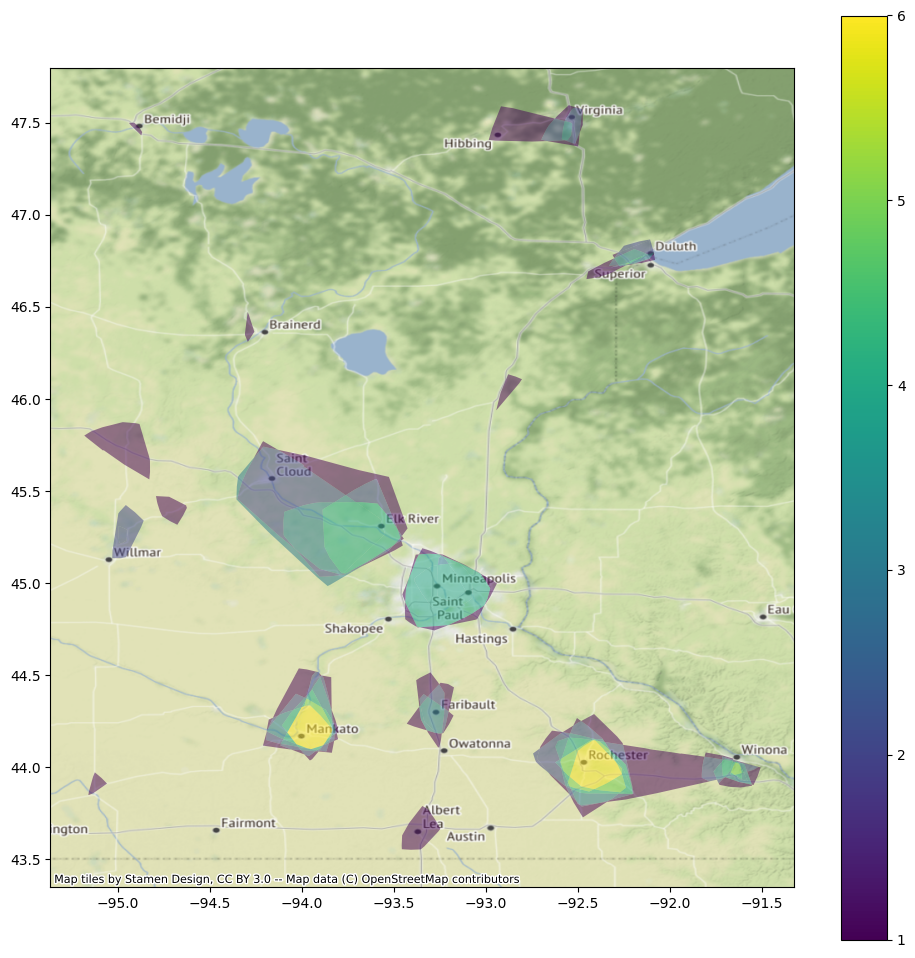

In [35]:
ax = union_df.plot(alpha=0.5, column="count_intersections", figsize=(12, 12), legend=True)
contextily.add_basemap(ax, crs=union_df.crs.to_string());